In [1]:
# -*- coding: utf-8 -*-

# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.initializers import (Zeros, glorot_normal, glorot_uniform)

In [3]:
from collections import namedtuple

DEFAULT_GROUP_NAME = "default_group"


# 统一输入
# SparseFeat继承了namedtuple, 通过__new__方法中设置的参数，实现对namedtuple中某些字段的初始化
class SparseFeat(namedtuple('SparseFeat',
                            ['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embedding_name',
                             'group_name'])):
    # 它的作用是阻止在实例化类时为实例分配dict，默认情况下每个类都会有一个dict, 通过__dict__访问，这个dict维护了这个实例的所有属性
    # 当需要创建大量的实例时，创建大量的__dict__会浪费大量的内存，所以这里使用__slots__()进行限制，当然如果需要某些属性被访问到，需要
    # 在__slots__()中将对应的属性填写进去
    __slots__ = ()

    # new方法是在__init__方法之前运行的，new方法的返回值是类的实例，也就是类中的self
    # new方法中传入的参数是cls,而init的方法传入的参数是self
    # __new__ 负责对象的创建，__init__ 负责对象的初始化
    # 这里使用__new__的原因是，这里最终是想创建一个namedtuple对象，并且避免namedtuple初始化时需要填写所有参数的的情况，使用了一个类来包装
    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, dtype="int32", embedding_name=None,
                group_name=DEFAULT_GROUP_NAME):
        if embedding_name is None:
            embedding_name = name
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))  # 如果没有指定embedding_dim的一个默认值，这个默认值是怎么来的？
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype,
                                              embedding_name, group_name)

    # 要想使用自定义的类作为字典的键，就需要重写类的哈希函数，否则无法将其作为字典的键来使用
    # 由于这个类不需要比较大小所以不必重写__eq__()方法
    def __hash__(self):
        return self.name.__hash__()


# 数值特征，这里需要注意，数值特征不一定只是一维的，也可以是一个多维的
class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32"):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype)

    def __hash__(self):
        return self.name.__hash__()


# 长度变化的稀疏特征，其实就是id序列特征
class VarLenSparseFeat(namedtuple('VarLenSparseFeat',
                                  ['sparsefeat', 'maxlen', 'combiner', 'length_name', 'weight_name', 'weight_norm'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None, weight_name=None, weight_norm=True):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name, weight_name,
                                                    weight_norm)

    # 由于这里传进来的sparsefeat, 本身就是一个自定义的类型，也有很多有用的信息，例如name, embedding_dim等等
    # 对于VarLenSparseFeat类来说，只不过是一个sparsefeat的序列，需要获取到sparsefeat的相关属性

    # 使用@property装饰器，将一个函数的返回值作为类的属性来使用
    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def use_hash(self):
        return self.sparsefeat.use_hash

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    def __hash__(self):
        return self.name.__hash__()

In [4]:
# 构建输入层
# 将输入的数据转换成字典的形式，定义输入层的时候让输入层的name和字典中特征的key一致，就可以使得输入的数据和对应的Input层对应
def build_input_layers(feature_columns):
    """构建Input层字典，并以dense和sparse两类字典的形式返回"""
    dense_input_dict, sparse_input_dict = {}, {}
    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            sparse_input_dict[fc.name] = Input(shape=(1, ), name=fc.name, dtype=fc.dtype)
        elif isinstance(fc, DenseFeat):
            dense_input_dict[fc.name] = Input(shape=(fc.dimension, ), name=fc.name, dtype=fc.dtype)
    return dense_input_dict, sparse_input_dict

# 构建embedding层
def build_embedding_layers(feature_columns, input_layer_dict, is_linear):
    # 定义一个embedding层对应的字典
    embedding_layers_dict = dict()
    
    # 将特征中的sparse特征筛选出来
    sparse_features_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    
    # 如果是用于线性部分的embedding层，其维度是1，否则维度是自己定义的embedding维度
    if is_linear:
        for fc in sparse_features_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, 1, name='1d_emb_'+fc.name)
    else:
        for fc in sparse_features_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, fc.embedding_dim, name='kd_emb_'+fc.name)
    
    return embedding_layers_dict

# 将所有的sparse特征embedding拼接
def concat_embedding_list(feature_columns, input_layer_dict, embedding_layer_dict, flatten=False):
    # 将sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns))

    embedding_list = []
    for fc in sparse_feature_columns:
        _input = input_layer_dict[fc.name] # 获取输入层 
        _embed = embedding_layer_dict[fc.name] # B x 1 x dim  获取对应的embedding层
        embed = _embed(_input) # B x dim  将input层输入到embedding层中

        # 是否需要flatten, 如果embedding列表最终是直接输入到Dense层中，需要进行Flatten，否则不需要
        if flatten:
            embed = Flatten()(embed)
        
        embedding_list.append(embed)
    
    return embedding_list 

def get_dnn_output(dnn_input, hidden_units=[1024, 512, 256], dnn_dropout=0.3, activation='relu'):
    
    # 建立dnn_network
    dnn_network = [Dense(units=unit, activation=activation) for unit in hidden_units]
    dropout = Dropout(dnn_dropout)
    
    # 前向传播
    x = dnn_input
    for dnn in dnn_network:
        x = dropout(dnn(x))
    
    return x

# 得到线性部分的计算结果, 即线性部分计算的前向传播逻辑
def get_linear_logits(dense_input_dict, sparse_input_dict, linear_feature_columns):
    """
    线性部分的计算，所有特征的Input层，然后经过一个全连接层线性计算结果logits
    即FM线性部分的那块计算w1x1+w2x2+...wnxn + b,只不过，连续特征和离散特征这里的线性计算还不太一样
        连续特征由于是数值，可以直接过全连接，得到线性这边的输出。 
        离散特征需要先embedding得到1维embedding，然后直接把这个1维的embedding相加就得到离散这边的线性输出。
    :param dense_input_dict: A dict. 连续特征构建的输入层字典 形式{'dense_name': Input(shape, name, dtype)}
    :param sparse_input_dict: A dict. 离散特征构建的输入层字典 形式{'sparse_name': Input(shape, name, dtype)}
    :param linear_feature_columns: A list. 里面的每个元素是namedtuple(元组的一种扩展类型，同时支持序号和属性名访问组件)类型，表示的是linear数据的特征封装版
    """
    # 把所有的dense特征合并起来,经过一个神经元的全连接，做的计算  w1x1 + w2x2 + w3x3....wnxn
    concat_dense_inputs = Concatenate(axis=1)(list(dense_input_dict.values()))
    dense_logits_output = Dense(1)(concat_dense_inputs) 
    
    # 获取linear部分sparse特征的embedding层，这里使用embedding的原因：
    # 对于linear部分直接将特征进行OneHot然后通过一个全连接层，当维度特别大的时候，计算比较慢
    # 使用embedding层的好处就是可以通过查表的方式获取到非零元素对应的权重，然后将这些权重相加，提升效率
    linear_embedding_layers = build_embedding_layers(linear_feature_columns, sparse_input_dict, is_linear=True)
    
    # 将一维的embedding拼接，注意这里需要一个Flatten层， 使维度对应
    sparse_1d_embed = []
    for fc in linear_feature_columns:
        # 离散特征要进行embedding
        if isinstance(fc, SparseFeat):
            # 找到对应Input层，然后后面接上embedding层
            feat_input = sparse_input_dict[fc.name]
            embed = Flatten()(linear_embedding_layers[fc.name](feat_input))
            sparse_1d_embed.append(embed)
    
    # embedding中查询得到的权重就是对应onehot向量中一个位置的权重，所以后面不用再接一个全连接了，本身一维的embedding就相当于全连接
    # 只不过是这里的输入特征只有0和1，所以直接向非零元素对应的权重相加就等同于进行了全连接操作(非零元素部分乘的是1)
    sparse_logits_output = Add()(sparse_1d_embed)
    
    # 最终将dense特征和sparse特征对应的logits相加，得到最终linear的logits
    linear_part = Add()([dense_logits_output, sparse_logits_output])
    
    return linear_part

class InteractingLayer(Layer):
    """A layer user in AutoInt that model the correction between different feature fields by multi-head self-att mechanism
        input: 3维张量, (none, field_num, embedding_size)
        output: 3维张量, (none, field_num, att_embedding_size * head_num)
    """
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, seed=2021):
        super(InteractingLayer, self).__init__()
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        
    
    def build(self, input_shape):
        embedding_size = int(input_shape[-1])
        
        # 定义三个矩阵Wq, Wk, Wv
        self.W_query = self.add_weight(name="query", shape=[embedding_size, self.att_embedding_size * self.head_num],
                                        dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed))
        self.W_key = self.add_weight(name="key", shape=[embedding_size, self.att_embedding_size * self.head_num], 
                                     dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed+1))
        self.W_value = self.add_weight(name="value", shape=[embedding_size, self.att_embedding_size * self.head_num],
                                      dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed+2))
        
        if self.use_res:
            self.W_res = self.add_weight(name="res", shape=[embedding_size, self.att_embedding_size * self.head_num],
                                        dtype=tf.float32, initializer=tf.keras.initializers.TruncatedNormal(seed=self.seed+3))
        
        super(InteractingLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs (none, field_nums, embed_num)
        
        querys = tf.tensordot(inputs, self.W_query, axes=(-1, 0))   # (None, field_nums, att_emb_size*head_num)
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_value, axes=(-1, 0))
        
        # 多头注意力计算 按照头分开  (head_num, None, field_nums, att_embed_size)
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # Q * K, key的后两维转置，然后再矩阵乘法 
        inner_product = tf.matmul(querys, keys, transpose_b=True)    # (head_num, None, field_nums, field_nums)
        normal_att_scores = tf.nn.softmax(inner_product, axis=-1)
        
        result = tf.matmul(normal_att_scores, values)   # (head_num, None, field_nums, att_embed_size)
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)  # (1, None, field_nums, att_emb_size*head_num)
        result = tf.squeeze(result, axis=0)  # (None, field_num, att_emb_size*head_num)
        
        if self.use_res:
            result += tf.tensordot(inputs, self.W_res, axes=(-1, 0))
        
        result = tf.nn.relu(result)
        
        return result


def AutoInt(linear_feature_columns, dnn_feature_columns, att_layer_num=3, att_embedding_size=8, att_head_num=2, att_res=True):
    """
    :param att_layer_num: transformer块的数量，一个transformer块里面是自注意力计算 + 残差计算
    :param att_embedding_size:  文章里面的d', 自注意力时候的att的维度
    :param att_head_num: 头的数量或者自注意力子空间的数量
    :param att_res: 是否使用残差网络
    """
    # 构建输入层，即所有特征对应的Input()层，这里使用字典的形式返回，方便后续构建模型
    dense_input_dict, sparse_input_dict = build_input_layers(linear_feature_columns+dnn_feature_columns)
    
    # 构建模型的输入层，模型的输入层不能是字典的形式，应该将字典的形式转换成列表的形式
    # 注意：这里实际的输入预Input层对应，是通过模型输入时候的字典数据的key与对应name的Input层
    input_layers = list(dense_input_dict.values()) + list(sparse_input_dict.values())
    
    # 线性部分的计算逻辑 -- linear
    linear_logits = get_linear_logits(dense_input_dict, sparse_input_dict, linear_feature_columns)
    
    # 构建维度为k的embedding层，这里使用字典的形式返回，方便后面搭建模型
    # 线性层和dnn层统一的embedding层
    embedding_layer_dict = build_embedding_layers(linear_feature_columns+dnn_feature_columns, sparse_input_dict, is_linear=False)
    
    # 构造self-att的输入
    att_sparse_kd_embed = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=False)
    att_input = Concatenate(axis=1)(att_sparse_kd_embed)   # (None, field_num, embed_num)
    
    # 下面的循环，就是transformer的前向传播，多个transformer块的计算逻辑
    for _ in range(att_layer_num):
        att_input = InteractingLayer(att_embedding_size, att_head_num, att_res)(att_input)
    att_output = Flatten()(att_input)
    #att_logits = Dense(1)(att_output)
    
    # DNN侧的计算逻辑 -- Deep
    # 将dnn_feature_columns里面的连续特征筛选出来，并把相应的Input层拼接到一块
    dnn_dense_feature_columns = list(filter(lambda x: isinstance(x, DenseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    dnn_dense_feature_columns = [fc.name for fc in dnn_dense_feature_columns]
    dnn_concat_dense_inputs = Concatenate(axis=1)([dense_input_dict[col] for col in dnn_dense_feature_columns])
    
    # 将dnn_feature_columns里面的离散特征筛选出来，相应的embedding层拼接到一块
    dnn_sparse_kd_embed = concat_embedding_list(dnn_feature_columns, sparse_input_dict, embedding_layer_dict, flatten=True)
    dnn_concat_sparse_kd_embed = Concatenate(axis=1)(dnn_sparse_kd_embed)
    
    # DNN层的输入和输出
    dnn_input = Concatenate(axis=1)([dnn_concat_dense_inputs, dnn_concat_sparse_kd_embed, att_output])
    dnn_out = get_dnn_output(dnn_input)
    dnn_logits = Dense(1)(dnn_out)
     
    # 三边的结果stack
    stack_output = Add()([linear_logits, dnn_logits])
    
    # 输出层
    output_layer = Dense(1, activation='sigmoid')(stack_output)
    
    model = Model(input_layers, output_layer)
    
    return model

In [5]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:

# 模型训练相关
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam



In [7]:
# 简单处理特征， 包括填充缺失值，数值处理， 类别编码
def data_process(data_df, dense_features, sparse_features):
    # 连续型特征用0填充缺失, 并进行对数转换
    data_df[dense_features] = data_df[dense_features].fillna(0.0)
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    # 离散型特征用-1填充，并进行LabelEncoder编码
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")
    for f in sparse_features:
        lbe = LabelEncoder()
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features+sparse_features]

In [8]:
"""读取数据"""
import pandas as pd
data = pd.read_csv('./criteo_sample.txt')

In [10]:

"""划分dense和sparse特征"""
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]

In [11]:

"""简单的数据预处理"""
from sklearn.preprocessing import LabelEncoder
train_data = data_process(data, dense_features, sparse_features)
train_data['label'] = data['label']


In [12]:
"""划分数据集"""
trnx, valx, trny, valy = train_test_split(train_data[dense_features+sparse_features], train_data['label'], test_size=0.1)

In [13]:
"""特征分组， 分成linear部分和DNN部分(根据实际场景进行选择)，并将分组之后的特征用namedtuple封装起来(DenseFeat, SparseFeat)"""
linear_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

In [14]:
"""构建AutoInt模型"""
model = AutoInt(linear_feature_columns, dnn_feature_columns)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
______________________________________________________________________________________________

In [15]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 20

In [16]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate),
                      metrics=['binary_crossentropy', AUC(name='auc')])

In [17]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)
]
#将输入数据转化成字典的形式输入
trnx_model_input = {name: trnx[name] for name in dense_features + sparse_features}
valx_model_input = {name: valx[name] for name in dense_features + sparse_features}

history = model.fit(
                    trnx_model_input, 
                    trny.values,
                    epochs=epochs,
                    #callbacks=callbacks,  # checkpoint
                    batch_size=batch_size,
                    validation_split=0.2
                    )

Train on 144 samples, validate on 36 samples
Epoch 1/20
144/144 [==============================] - 8s 53ms/sample - loss: 1.1952 - binary_crossentropy: 1.1952 - auc: 0.4008 - val_loss: 0.8159 - val_binary_crossentropy: 0.8159 - val_auc: 0.5567
Epoch 2/20
144/144 [==============================] - 0s 702us/sample - loss: 0.9931 - binary_crossentropy: 0.9931 - auc: 0.4123 - val_loss: 0.6662 - val_binary_crossentropy: 0.6662 - val_auc: 0.5197
Epoch 3/20
144/144 [==============================] - 0s 574us/sample - loss: 0.8043 - binary_crossentropy: 0.8043 - auc: 0.4140 - val_loss: 0.6441 - val_binary_crossentropy: 0.6441 - val_auc: 0.5123
Epoch 4/20
144/144 [==============================] - 0s 575us/sample - loss: 0.6846 - binary_crossentropy: 0.6846 - auc: 0.4759 - val_loss: 0.5751 - val_binary_crossentropy: 0.5751 - val_auc: 0.5517
Epoch 5/20
144/144 [==============================] - 0s 538us/sample - loss: 0.5584 - binary_crossentropy: 0.5584 - auc: 0.6159 - val_loss: 0.5199 - val_bi

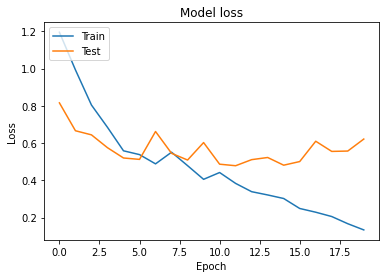

In [18]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
"""模型评估"""
print('val AUC: %f' % model.evaluate(valx_model_input, valy, batch_size=batch_size)[1])

20/20 [==============================] - 0s 2ms/sample - loss: 1.1588 - binary_crossentropy: 1.1588 - auc: 0.4583
val AUC: 1.158784


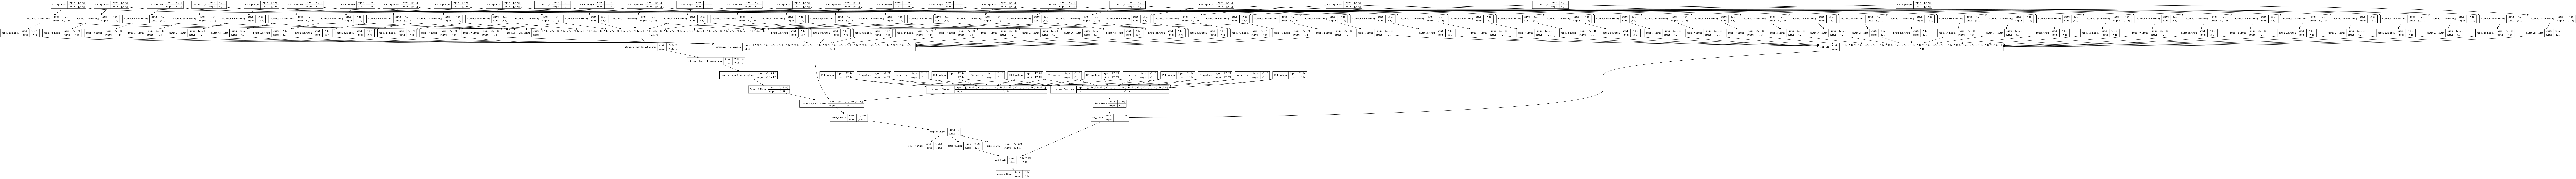

In [20]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./AutoInt_arc.png', show_shapes=True)